In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer, RobustScaler, PowerTransformer, StandardScaler
from sklearn.ensemble import RandomForestClassifier  # Example model
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


In [2]:
dataset = pd.read_csv("Pakistani_Diabetes_Dataset.csv")
dataset

,age,gender,reguglacin,wt,BMI,wst,sys,dia,his,A1c,B.S.R,vision,Exr,dipsia,uria,Dur,neph,HDL,Outcome
0,60.0,1,0,76.0,29.90,41.0,130,90,0,8.90,278,0,30,1,0,5.0,0,60,1
1,57.0,1,1,64.0,24.30,39.0,120,80,1,8.50,165,0,20,1,1,20.0,0,42,1
2,58.0,0,0,73.0,25.20,34.0,140,90,0,5.65,130,1,20,0,0,0.0,0,54,0
3,27.0,0,1,60.0,22.01,30.0,110,70,0,5.00,95,0,15,0,0,0.0,0,57,0
4,56.0,1,0,70.0,25.80,43.0,125,90,0,8.30,139,1,40,1,0,5.0,1,53,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,22.0,0,0,54.0,17.08,40.0,143,85,1,5.00,165,0,15,0,0,0.0,0,54,0
908,32.0,0,1,52.0,18.50,28.0,138,95,1,4.70,87,0,0,0,0,0.0,0,54,0
909,22.0,0,0,78.0,26.14,32.0,183,88,1,4.50,100,0,0,1,0,0.0,0,40,1
910,18.0,1,1,53.0,20.05,33.0,195,93,1,4.70,74,1,15,0,0,0.0,0,46,0


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         912 non-null    float64
 1   gender      912 non-null    int64  
 2   reguglacin  912 non-null    int64  
 3   wt          912 non-null    float64
 4   BMI         912 non-null    float64
 5   wst         912 non-null    float64
 6   sys         912 non-null    int64  
 7   dia         912 non-null    int64  
 8   his         912 non-null    int64  
 9   A1c         912 non-null    float64
 10  B.S.R       912 non-null    int64  
 11  vision      912 non-null    int64  
 12  Exr         912 non-null    int64  
 13  dipsia      912 non-null    int64  
 14  uria        912 non-null    int64  
 15  Dur         912 non-null    float64
 16  neph        912 non-null    int64  
 17  HDL         912 non-null    int64  
 18  Outcome     912 non-null    int64  
dtypes: float64(6), int64(13)
memo

The name of the features seems to look less informative. To ensure what we are dealing with, we can rename them to make them sound more familiar.

In [4]:
dataset.rename(columns={
    "wt": "weight_kg",
    "BMI": "body_mass_index",
    "wst": "waist_inches",
    "sys": "systolic_bp",
    "dia": "diastolic_bp",
    "his": "familyhist_diabetes",
    "A1c": "hemoglobina1c",
    "B.S.R": "blood_sugar_random",
    "vision": "vision_impair",
    "Exr": "exercise_minutes",
    "dipsia": "polydipsia",
    "uria": "polyuria",
    "Dur": "diabetes_duration",
    "neph": "nephropathy",
    "HDL": "hdl_cholesterol",
    "Outcome": "diabetes_outcome",
},
inplace=True)


In [5]:

dataset.duplicated().sum()

np.int64(2)

In [6]:
dataset.drop_duplicates(inplace=True)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 910 entries, 0 to 911
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  910 non-null    float64
 1   gender               910 non-null    int64  
 2   reguglacin           910 non-null    int64  
 3   weight_kg            910 non-null    float64
 4   body_mass_index      910 non-null    float64
 5   waist_inches         910 non-null    float64
 6   systolic_bp          910 non-null    int64  
 7   diastolic_bp         910 non-null    int64  
 8   familyhist_diabetes  910 non-null    int64  
 9   hemoglobina1c        910 non-null    float64
 10  blood_sugar_random   910 non-null    int64  
 11  vision_impair        910 non-null    int64  
 12  exercise_minutes     910 non-null    int64  
 13  polydipsia           910 non-null    int64  
 14  polyuria             910 non-null    int64  
 15  diabetes_duration    910 non-null    float64


In [8]:

def outlier_detect_iqr2(df,col1,col2):
    outliers_list=[]

    for col in [col1,col2]:
        Q3 = df[col].quantile(0.75)
        Q1 = df[col].quantile(0.25)
        IQR = Q3-Q1
    upper_bound= Q3+1.5*IQR
    lower_bound= Q1-1.5*IQR

    outliers = df[(df[col]<lower_bound)|(df[col]>upper_bound)]
    outliers_list.append(outliers)

    results = pd.concat(outliers_list)
    return results


In [9]:
#function to find value greater than specified value(manually detect outliers)
def value_greater_than(df,column_name,value):
    if column_name not in df:
        raise ValueError(f"Column {column_name} does not exist in dataframe. Maybe look for spelling mistakes or case sensitivity.")
    result= df[df[column_name]<value]
    return result



In [10]:
#Column names are case sensitive when using them in code, remember that!
column = "diastolic_bp"
value=50
value_greater_than(dataset,column,value)


,age,gender,reguglacin,weight_kg,body_mass_index,waist_inches,systolic_bp,diastolic_bp,familyhist_diabetes,hemoglobina1c,blood_sugar_random,vision_impair,exercise_minutes,polydipsia,polyuria,diabetes_duration,nephropathy,hdl_cholesterol,diabetes_outcome
411,23.0,1,1,43.0,17.33,26.0,100,40,0,4.7,82,1,15,0,0,0.0,0,58,0
456,21.0,0,0,62.0,20.78,30.0,110,20,0,4.5,70,0,15,0,0,0.0,0,52,0
485,22.0,0,0,70.0,23.46,32.0,120,20,1,4.7,80,0,0,0,0,0.0,0,53,0
632,22.0,0,1,74.0,19.68,34.0,110,44,0,4.5,84,0,30,0,0,0.0,0,35,0


In [11]:
dataset['body_mass_index'] = dataset['body_mass_index'].clip(upper=60)
dataset['waist_inches'] = dataset['waist_inches'].clip(upper=50)
dataset['systolic_bp'] = dataset['systolic_bp'].clip(upper=210  )


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'gender'}>,
        <Axes: title={'center': 'reguglacin'}>,
        <Axes: title={'center': 'weight_kg'}>],
       [<Axes: title={'center': 'body_mass_index'}>,
        <Axes: title={'center': 'waist_inches'}>,
        <Axes: title={'center': 'systolic_bp'}>,
        <Axes: title={'center': 'diastolic_bp'}>],
       [<Axes: title={'center': 'familyhist_diabetes'}>,
        <Axes: title={'center': 'hemoglobina1c'}>,
        <Axes: title={'center': 'blood_sugar_random'}>,
        <Axes: title={'center': 'vision_impair'}>],
       [<Axes: title={'center': 'exercise_minutes'}>,
        <Axes: title={'center': 'polydipsia'}>,
        <Axes: title={'center': 'polyuria'}>,
        <Axes: title={'center': 'diabetes_duration'}>],
       [<Axes: title={'center': 'nephropathy'}>,
        <Axes: title={'center': 'hdl_cholesterol'}>,
        <Axes: title={'center': 'diabetes_outcome'}>, <Axes: >]],
      dtype=object)

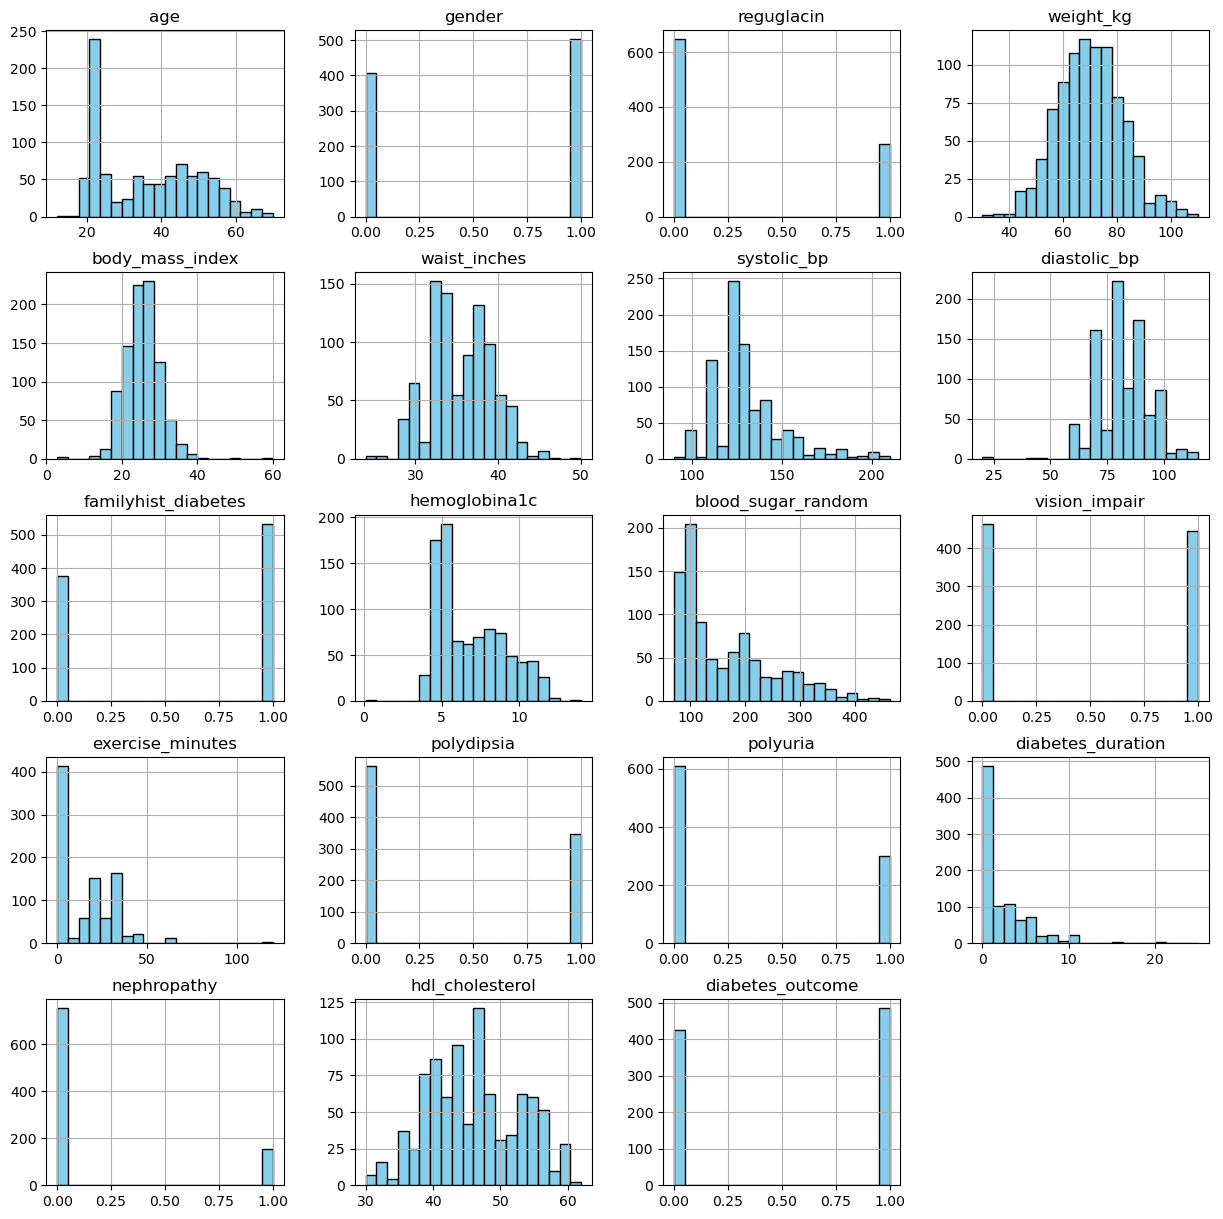

In [12]:
#Histogram for distribution of data
dataset.hist(figsize=(15,15), bins=20, color='skyblue', edgecolor='black')

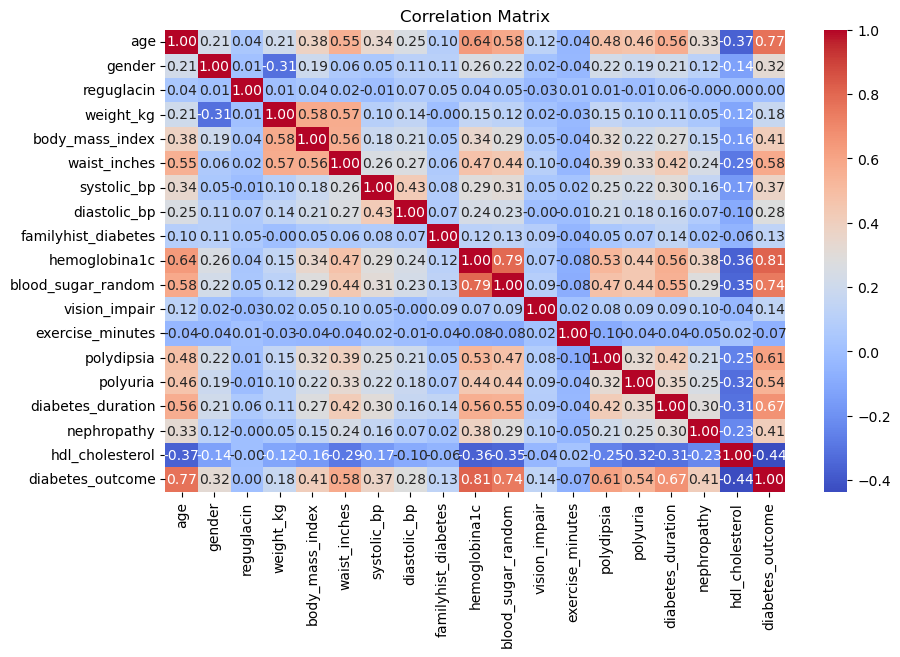

In [13]:
# 2. Plot the correlation matrix
plt.figure(figsize=(10, 6))
correlation_matrix = dataset.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

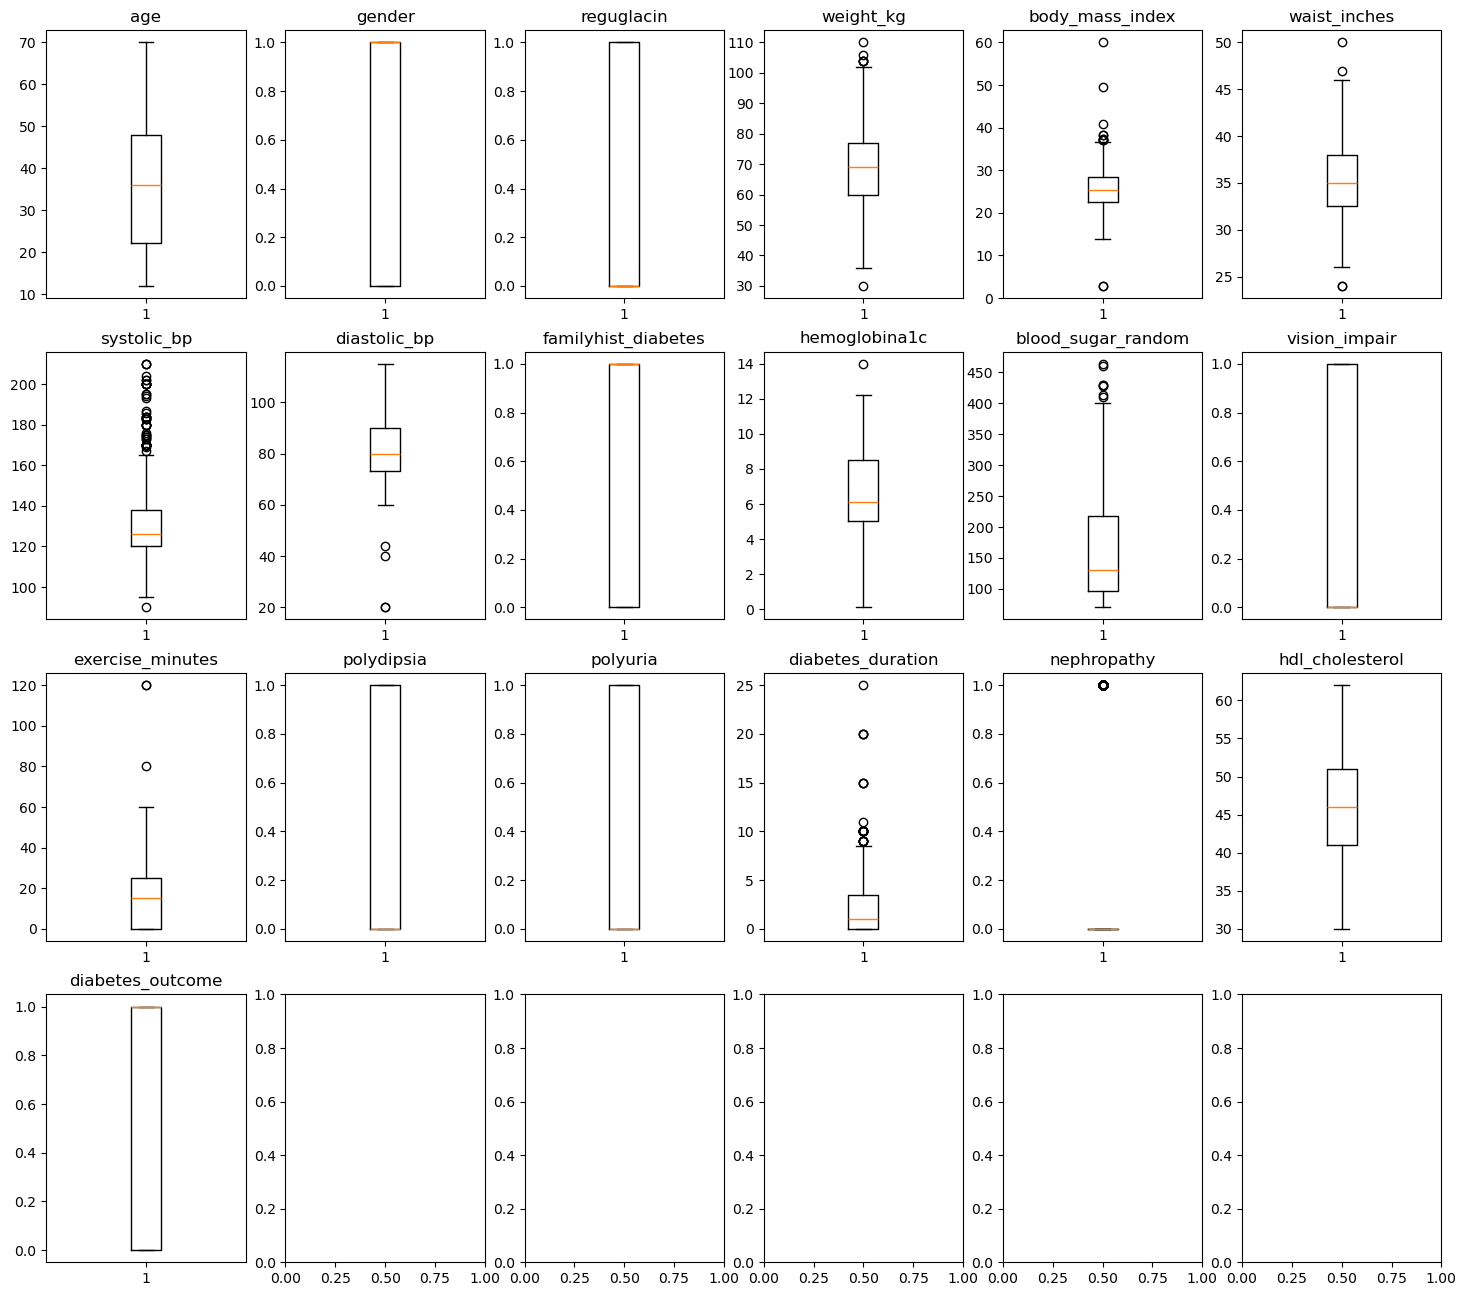

In [14]:
n_cols = 6
n_rows = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*4))  # Create grid

axes = axes.flatten()  # Flatten the 2D array into 1D

for i, column in enumerate(dataset.columns):  # Loop through all 18 columns
    
        axes[i].boxplot(dataset[column])  # Plot the boxplot on the ith subplot
        axes[i].set_title(f"{column}") 
plt.show()

In [15]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(dataset)  # Fit and transform the training data

In [38]:
df = pd.DataFrame(df_scaled, columns=dataset.columns)

In [39]:
df.head()

,age,gender,reguglacin,weight_kg,body_mass_index,waist_inches,systolic_bp,diastolic_bp,familyhist_diabetes,hemoglobina1c,blood_sugar_random,vision_impair,exercise_minutes,polydipsia,polyuria,diabetes_duration,nephropathy,hdl_cholesterol,diabetes_outcome
0,0.932039,0.0,0.0,0.411765,0.801728,1.090909,0.222222,0.597015,-1.0,0.800000,1.209877,0.0,0.6,1.0,0.0,1.142857,0.0,1.4,0.0
1,0.815534,0.0,1.0,-0.294118,-0.165875,0.727273,-0.333333,0.000000,0.0,0.685714,0.279835,0.0,0.2,1.0,1.0,5.428571,0.0,-0.4,0.0
2,0.854369,-1.0,0.0,0.235294,-0.010367,-0.181818,0.777778,0.597015,-1.0,-0.128571,-0.008230,1.0,0.2,0.0,0.0,-0.285714,0.0,0.8,-1.0
3,-0.349515,-1.0,1.0,-0.529412,-0.561555,-0.909091,-0.888889,-0.597015,-1.0,-0.314286,-0.296296,0.0,0.0,0.0,0.0,-0.285714,0.0,1.1,-1.0
4,0.776699,0.0,0.0,0.058824,0.093305,1.454545,-0.055556,0.597015,-1.0,0.628571,0.065844,1.0,1.0,1.0,0.0,1.142857,1.0,0.7,0.0


In [15]:

# Features and target
X = dataset.drop(["diabetes_outcome"], axis=1)  # Features
y = dataset["diabetes_outcome"]  # Target

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Validation split (from training set, 80-20 again)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


## Variables Created in Train-Test and Validation Split

### Variables and Their Usage

1. **`X`**:  
   - **Description**: Contains all the features of the dataset except the target column (`diabetes_outcome`).  
   - **Usage**: Used as the input features for splitting into training, validation, and test sets.

2. **`y`**:  
   - **Description**: Contains the target column (`diabetes_outcome`), which is the label we want to predict.  
   - **Usage**: Used as the target labels for splitting into training, validation, and test sets.

3. **`X_train`**:  
   - **Description**: Subset of `X` used for training the model.  
   - **Usage**: Contains the majority of the feature data for model training.

4. **`X_test`**:  
   - **Description**: Subset of `X` used for testing the model.  
   - **Usage**: Used to evaluate the model's performance on unseen data after training.

5. **`y_train`**:  
   - **Description**: Subset of `y` used as labels for training the model.  
   - **Usage**: Corresponds to `X_train` and provides the target values for supervised learning.

6. **`y_test`**:  
   - **Description**: Subset of `y` used as labels for testing the model.  
   - **Usage**: Corresponds to `X_test` and is used to validate the model's predictions.

7. **`X_val`**:  
   - **Description**: Subset of `X_train` used for model validation during training.  
   - **Usage**: Used to fine-tune model hyperparameters and prevent overfitting.

8. **`y_val`**:  
   - **Description**: Subset of `y_train` used as labels for validation.  
   - **Usage**: Corresponds to `X_val` and provides the target values for validation.

### Splitting Details:
1. **Train-Test Split**:  
   - 80% of the data is used for training (`X_train`, `y_train`), and 20% is used for testing (`X_test`, `y_test`).  
   - Ensures the model is evaluated on unseen data.

2. **Validation Split**:  
   - Further splits the training set into 80% training (`X_train`, `y_train`) and 20% validation (`X_val`, `y_val`).  
   - Helps tune hyperparameters and assess the model's performance during training.



In [16]:
# Apply SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE

print("Class distribution after SMOTE:", Counter(y_train_smote))

Class distribution after SMOTE: Counter({1: 311, 0: 311})


In [17]:
# List of one-hot encoded features to drop
encoded_features = [
    "nephropathy",
    "polyuria",
    "polydipsia",
    "vision_impair",
    "familyhist_diabetes",
    "reguglacin",
    "gender"
]

#Separate Variables for encoded(0,1) features to concatenate them later
X_train_smote_enc = X_train_smote[encoded_features]
X_test_enc = X_test[encoded_features]
X_val_enc = X_val[encoded_features]

# Drop one-hot encoded features from the X sets(Continous features)
X_train_smote_cont = X_train_smote.drop(encoded_features, axis=1)
X_test_cont = X_test.drop(encoded_features, axis=1)
X_val_cont = X_val.drop(encoded_features, axis=1)



In [18]:
X_train_smote_cont.info()
X_test_cont.info()
X_val_cont.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 0 to 621
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 622 non-null    float64
 1   weight_kg           622 non-null    float64
 2   body_mass_index     622 non-null    float64
 3   waist_inches        622 non-null    float64
 4   systolic_bp         622 non-null    int64  
 5   diastolic_bp        622 non-null    int64  
 6   hemoglobina1c       622 non-null    float64
 7   blood_sugar_random  622 non-null    int64  
 8   exercise_minutes    622 non-null    int64  
 9   diabetes_duration   622 non-null    float64
 10  hdl_cholesterol     622 non-null    int64  
dtypes: float64(6), int64(5)
memory usage: 53.6 KB
<class 'pandas.core.frame.DataFrame'>
Index: 182 entries, 590 to 95
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age

In [19]:

scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train_smote_cont)  # Fit and transform the training data
X_test_scaled = scaler.transform(X_test_cont)  # Transform the test data using the same scaler
X_val_scaled = scaler.transform(X_val_cont)  # Transform the validation data using the same scaler


In [20]:
X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train_smote_cont.columns)
X_test_scaled = pd.DataFrame(X_test_scaled,columns=X_test_cont.columns)
X_val_scaled = pd.DataFrame(X_val_scaled,columns=X_val_cont.columns)

In [21]:
X_train_final = pd.concat([X_train_scaled,X_train_smote_enc], axis=1)
X_test_final = pd.concat([X_test_scaled,X_test_enc], axis=1)
X_val_final = pd.concat([X_val_scaled,X_val_enc], axis=1)

In [16]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [17]:

# Define the Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
            nn.Sigmoid()  # Output values between 0 and 1
        )

    def forward(self, x):
        return self.model(x)

In [18]:
# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output probability (0 = fake, 1 = real)
        )

    def forward(self, x):
        return self.model(x)

In [27]:
# Hyperparameters
latent_dim = 100  # Size of the random noise vector
input_dim = df_scaled.shape[1]  # Number of features in your dataset
batch_size = 910
epochs = 10000
lr = 0.0002

In [28]:

# Initialize Generator and Discriminator
generator = Generator(latent_dim, input_dim)
discriminator = Discriminator(input_dim)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
criterion = nn.BCELoss()

In [29]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available! Using GPU.")
    device = torch.device("cuda")  # Use GPU
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")  # Use CPU

# Print the device being used
print("Using device:", device)
generator.to(device)
discriminator.to(device)

CUDA is available! Using GPU.
Using device: cuda


Discriminator(
  (model): Sequential(
    (0): Linear(in_features=19, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [30]:
# Training loop
for epoch in range(epochs):
    # Train Discriminator
    # Access rows using .iloc or convert DataFrame to NumPy array
    data_tensor = torch.tensor(df_scaled, dtype=torch.float32).to(device)
    real_labels = torch.ones(batch_size, 1, device=device)

    noise = torch.randn(batch_size, latent_dim, device=device)
    fake_data = generator(noise)
    fake_labels = torch.zeros(batch_size, 1, device=device)

    # Discriminator loss on real data
    optimizer_D.zero_grad()
    real_loss = criterion(discriminator(data_tensor), real_labels)

    # Discriminator loss on fake data
    fake_loss = criterion(discriminator(fake_data.detach()), fake_labels)
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_D.step()

    # Train Generator
    optimizer_G.zero_grad()
    valid_labels = torch.ones(batch_size, 1, device=device)
    g_loss = criterion(discriminator(fake_data), valid_labels)
    g_loss.backward()
    optimizer_G.step()

    # Print progress
    if epoch % 1000 == 0:
        print(f"Epoch: {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

Epoch: 0, D Loss: 1.3880932331085205, G Loss: 0.6944417357444763
Epoch: 1000, D Loss: 0.05365556851029396, G Loss: 7.922353267669678
Epoch: 2000, D Loss: 0.00011697041190927848, G Loss: 9.355082511901855
Epoch: 3000, D Loss: 3.597946488298476e-05, G Loss: 10.597525596618652
Epoch: 4000, D Loss: 1.681211324466858e-05, G Loss: 11.38396167755127
Epoch: 5000, D Loss: 8.787164006207604e-06, G Loss: 12.041096687316895
Epoch: 6000, D Loss: 4.826712029171176e-06, G Loss: 12.644660949707031
Epoch: 7000, D Loss: 2.726829961829935e-06, G Loss: 13.221213340759277
Epoch: 8000, D Loss: 1.5663854355807416e-06, G Loss: 13.780240058898926
Epoch: 9000, D Loss: 9.093731705434038e-07, G Loss: 14.328505516052246


In [31]:
generator.eval()  # Set the generator to evaluation mode

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=19, bias=True)
    (7): Sigmoid()
  )
)

In [32]:
# Number of synthetic samples to generate
num_samples = 1000  # Adjust as needed

# Generate random noise (latent vectors)
noise = torch.randn(num_samples, latent_dim, device=device)

# Generate synthetic data
with torch.no_grad():  # Disable gradient calculation for inference
    synthetic_data = generator(noise).cpu().numpy()

In [34]:
# Convert synthetic data to a DataFrame
synthetic_df = pd.DataFrame(synthetic_data, columns=dataset.columns)

In [35]:
synthetic_df.head()

,age,gender,reguglacin,weight_kg,body_mass_index,waist_inches,systolic_bp,diastolic_bp,familyhist_diabetes,hemoglobina1c,blood_sugar_random,vision_impair,exercise_minutes,polydipsia,polyuria,diabetes_duration,nephropathy,hdl_cholesterol,diabetes_outcome
0,1.0,6.913154e-15,1.0,1.382168e-13,1.0,6.348507e-17,1.0,3.597769e-14,1.829066e-15,1.0,1.0,2.200046e-09,9.190292e-14,1.0,2.451895e-09,1.0,1.0,1.051620e-14,4.921121e-15
1,1.0,7.883832e-18,1.0,2.683897e-16,1.0,3.414114e-20,1.0,8.816519e-17,1.320318e-18,1.0,1.0,4.083630e-11,1.710296e-16,1.0,6.207286e-11,1.0,1.0,1.335790e-17,6.378241e-18
2,1.0,4.957145e-15,1.0,1.010516e-13,1.0,4.356343e-17,1.0,2.446643e-14,1.273654e-15,1.0,1.0,1.742648e-09,6.680108e-14,1.0,1.663703e-09,1.0,1.0,7.953805e-15,3.619925e-15
3,1.0,1.826359e-13,1.0,2.372917e-12,1.0,3.445681e-15,1.0,1.056204e-12,5.274250e-14,1.0,1.0,2.111201e-08,1.945367e-12,1.0,2.451705e-08,1.0,1.0,2.688425e-13,1.574456e-13
4,1.0,2.346032e-16,1.0,4.995282e-15,1.0,1.734479e-18,1.0,2.126762e-15,4.505786e-17,1.0,1.0,3.583361e-10,3.876463e-15,1.0,4.549065e-10,1.0,1.0,3.547268e-16,1.942719e-16


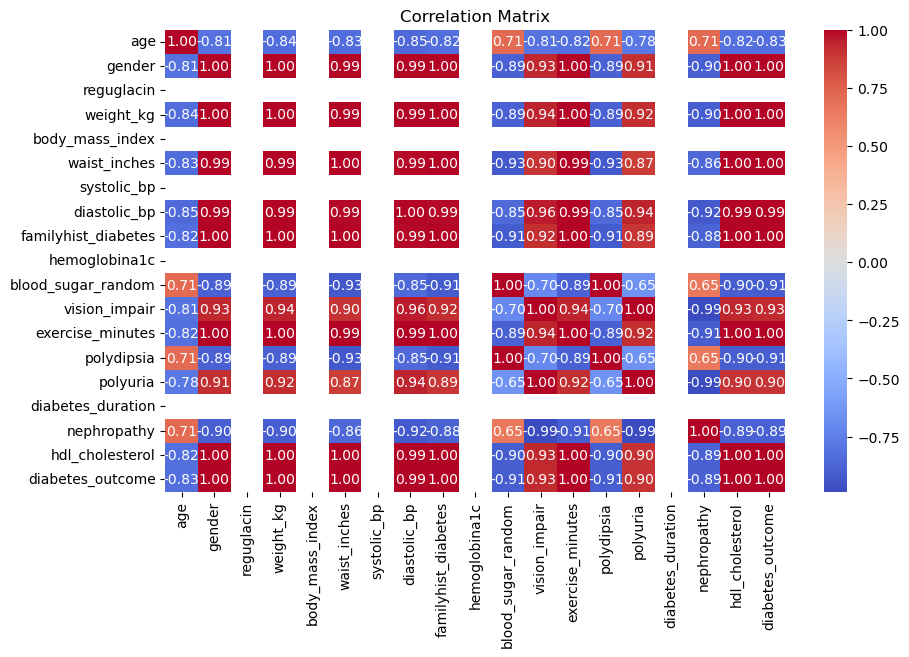

In [36]:
# 2. Plot the correlation matrix
plt.figure(figsize=(10, 6))
correlation_matrix = synthetic_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

In [68]:
synthetic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1000 non-null   float32
 1   weight_kg            1000 non-null   float32
 2   body_mass_index      1000 non-null   float32
 3   waist_inches         1000 non-null   float32
 4   systolic_bp          1000 non-null   float32
 5   diastolic_bp         1000 non-null   float32
 6   hemoglobina1c        1000 non-null   float32
 7   blood_sugar_random   1000 non-null   float32
 8   exercise_minutes     1000 non-null   float32
 9   diabetes_duration    1000 non-null   float32
 10  hdl_cholesterol      1000 non-null   float32
 11  nephropathy          1000 non-null   float32
 12  polyuria             1000 non-null   float32
 13  polydipsia           1000 non-null   float32
 14  vision_impair        1000 non-null   float32
 15  familyhist_diabetes  1000 non-null   fl

In [70]:
synthetic_df.to_csv('synthetic_data.csv', index=False)

In [22]:
X_train_smote_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 0 to 621
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 622 non-null    float64
 1   weight_kg           622 non-null    float64
 2   body_mass_index     622 non-null    float64
 3   waist_inches        622 non-null    float64
 4   systolic_bp         622 non-null    float64
 5   diastolic_bp        622 non-null    float64
 6   hemoglobina1c       622 non-null    float64
 7   blood_sugar_random  622 non-null    float64
 8   exercise_minutes    622 non-null    float64
 9   diabetes_duration   622 non-null    float64
 10  hdl_cholesterol     622 non-null    float64
dtypes: float64(11)
memory usage: 53.6 KB


C:\Users\tahir\AppData\Local\Temp\ipykernel_19088\3928999803.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(X_train_smote.columns, rotation=90)
C:\Users\tahir\AppData\Local\Temp\ipykernel_19088\3928999803.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(X_test.columns, rotation=90)
C:\Users\tahir\AppData\Local\Temp\ipykernel_19088\3928999803.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(X_val.columns, rotation=90)


[Text(0, 0, 'age'),
 Text(1, 0, 'weight_kg'),
 Text(2, 0, 'body_mass_index'),
 Text(3, 0, 'waist_inches'),
 Text(4, 0, 'systolic_bp'),
 Text(5, 0, 'diastolic_bp'),
 Text(6, 0, 'hemoglobina1c'),
 Text(7, 0, 'blood_sugar_random'),
 Text(8, 0, 'exercise_minutes'),
 Text(9, 0, 'diabetes_duration'),
 Text(10, 0, 'hdl_cholesterol')]

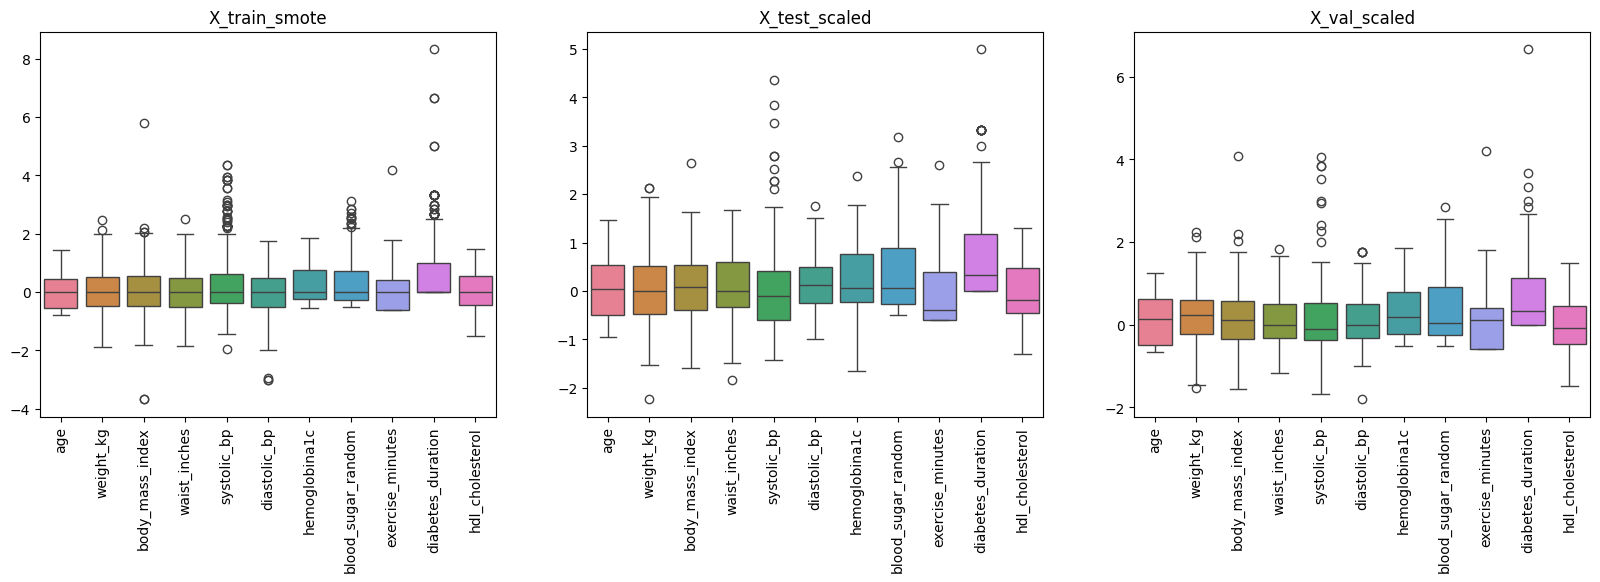

In [155]:

# Visualizing the transformations
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Original data (before scaling)
axes[0].set_title('X_train_smote')
sns.boxplot(data=X_train_smote_scaled, ax=axes[0])
axes[0].set_xticklabels(X_train_smote.columns, rotation=90)

# Quantile transformed data
axes[1].set_title('X_test_scaled')
sns.boxplot(data=X_test_scaled, ax=axes[1])
axes[1].set_xticklabels(X_test.columns, rotation=90)

# Robust scaled data
axes[2].set_title('X_val_scaled')
sns.boxplot(data=X_val_scaled, ax=axes[2])
axes[2].set_xticklabels(X_val.columns, rotation=90)

In [107]:
X = dataset.drop(["diabetes_outcome",
                  "nephropathy",
                  "polyuria",
                  "polydipsia",
                  "vision_impair",
                  "familyhist_diabetes",
                  "reguglacin",
                  "gender",
                  ],axis=1)

X

,age,weight_kg,body_mass_index,waist_inches,systolic_bp,diastolic_bp,hemoglobina1c,blood_sugar_random,exercise_minutes,diabetes_duration,hdl_cholesterol
0,60.0,76.0,29.90,41.0,130,90,8.90,278,30,5.0,60
1,57.0,64.0,24.30,39.0,120,80,8.50,165,20,20.0,42
2,58.0,73.0,25.20,34.0,140,90,5.65,130,20,0.0,54
3,27.0,60.0,22.01,30.0,110,70,5.00,95,15,0.0,57
4,56.0,70.0,25.80,43.0,125,90,8.30,139,40,5.0,53
...,...,...,...,...,...,...,...,...,...,...,...
907,22.0,54.0,17.08,40.0,143,85,5.00,165,15,0.0,54
908,32.0,52.0,18.50,28.0,138,95,4.70,87,0,0.0,54
909,22.0,78.0,26.14,32.0,183,88,4.50,100,0,0.0,40
910,18.0,53.0,20.05,33.0,195,93,4.70,74,15,0.0,46


In [109]:

# Apply scaling techniques
quantile_scaler = QuantileTransformer(output_distribution='normal', n_quantiles=910)
robust_scaler = RobustScaler()
power_scaler = PowerTransformer(method='yeo-johnson')

In [110]:
# Fit and transform data
X_quantile = quantile_scaler.fit_transform(X)
X_robust = robust_scaler.fit_transform(X)
X_power = power_scaler.fit_transform(X)


C:\Users\tahir\AppData\Local\Temp\ipykernel_19088\2379965235.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(X.columns, rotation=90)
C:\Users\tahir\AppData\Local\Temp\ipykernel_19088\2379965235.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(X.columns, rotation=90)
C:\Users\tahir\AppData\Local\Temp\ipykernel_19088\2379965235.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(X.columns, rotation=90)
C:\Users\tahir\AppData\Local\Temp\ipykernel_19088\2379965235.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[3].set_xticklabels(X.columns, rotation=90)


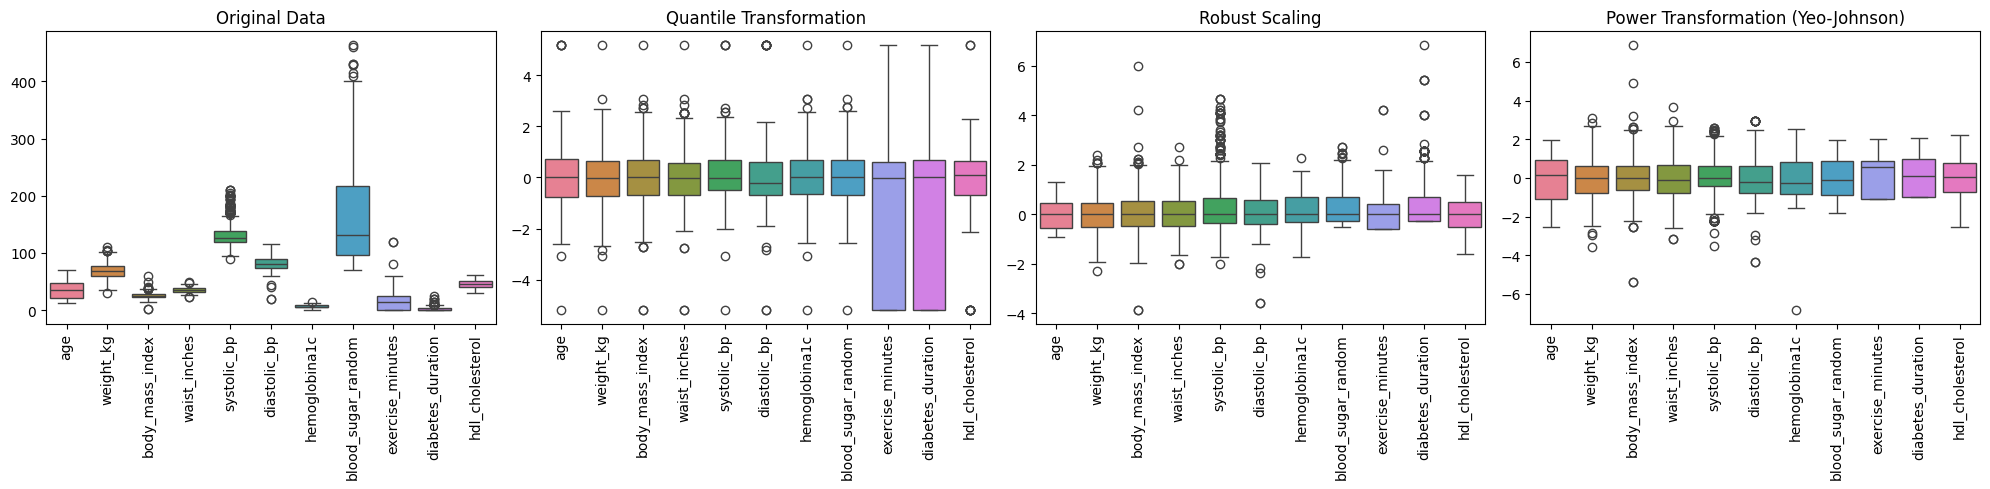

In [89]:

# Visualizing the transformations
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Original data (before scaling)
axes[0].set_title('Original Data')
sns.boxplot(data=X, ax=axes[0])
axes[0].set_xticklabels(X.columns, rotation=90)

# Quantile transformed data
axes[1].set_title('Quantile Transformation')
sns.boxplot(data=X_quantile, ax=axes[1])
axes[1].set_xticklabels(X.columns, rotation=90)

# Robust scaled data
axes[2].set_title('Robust Scaling')
sns.boxplot(data=X_robust, ax=axes[2])
axes[2].set_xticklabels(X.columns, rotation=90)

# Power transformed data
axes[3].set_title('Power Transformation (Yeo-Johnson)')
sns.boxplot(data=X_power, ax=axes[3])
axes[3].set_xticklabels(X.columns, rotation=90)

plt.tight_layout()
plt.show()


**Observations:**

1. **Original Data:**
   - The boxplots show significant variations in scale across the features. Some features have a much wider spread than others.
   - The presence of outliers is evident in several features, such as `weight_kg`, `blood_sugar_random`, and `hdl_cholesterol`.

2. **Quantile Transformation:**
   - This transformation has effectively reduced the spread of the features, making them more comparable.
   - The boxplots are now more compact and aligned, indicating that the scaling has brought the features to a similar scale.
   - The outliers appear to have been mitigated to some extent.

3. **Robust Scaling:**
   - This technique has also reduced the spread, but to a lesser extent compared to quantile transformation.
   - The presence of outliers is still noticeable in some features.

4. **Power Transformation (Yeo-Johnson):**
   - This transformation has a similar effect to quantile transformation, reducing the spread and making the features more comparable.
   - The outliers seem to be less prominent compared to robust scaling.


In [120]:

encoded_features = dataset[["diabetes_outcome",
                            "nephropathy",
                            "polyuria",
                            "polydipsia",
                            "vision_impair",
                            "familyhist_diabetes",
                            "reguglacin",
                            "gender"]]
encoded_features = encoded_features.reset_index(drop=True)
# Convert the scaled arrays back to DataFrames and keep original column names
X_scaled_power_df = pd.DataFrame(X_power, columns=X.columns)
X_scaled_quantile_df = pd.DataFrame(X_quantile, columns=X.columns)
X_scaled_robust_df = pd.DataFrame(X_robust, columns=X.columns)

# Concatenate the scaled dataframes with encoded features
df_power = pd.concat([X_scaled_power_df, encoded_features], axis=1)
df_quantile = pd.concat([X_scaled_quantile_df, encoded_features], axis=1)
df_robust = pd.concat([X_scaled_robust_df, encoded_features], axis=1)

In [125]:
df_quantile.info()
df_power.info()
df_robust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  910 non-null    float64
 1   weight_kg            910 non-null    float64
 2   body_mass_index      910 non-null    float64
 3   waist_inches         910 non-null    float64
 4   systolic_bp          910 non-null    float64
 5   diastolic_bp         910 non-null    float64
 6   hemoglobina1c        910 non-null    float64
 7   blood_sugar_random   910 non-null    float64
 8   exercise_minutes     910 non-null    float64
 9   diabetes_duration    910 non-null    float64
 10  hdl_cholesterol      910 non-null    float64
 11  diabetes_outcome     910 non-null    int64  
 12  nephropathy          910 non-null    int64  
 13  polyuria             910 non-null    int64  
 14  polydipsia           910 non-null    int64  
 15  vision_impair        910 non-null    int

In [42]:
X = dataset.drop("diabetes_outcome",axis=1)
y = dataset["diabetes_outcome"]

X_train, X_test,y_train,y_test = train_test_split (X,y,test_size=0.2,random_state=42)

print(f"X_train:{X_train.shape}")
print(f"X_test:{X_test.shape}")
print(f"y_train:{y_train.shape}")
print(f"y_test:{y_test.shape}")


X_train:(728, 18)
X_test:(182, 18)
y_train:(728,)
y_test:(182,)


In [43]:
# Create pipeline with Quantile Transformation
pipeline_quantile = Pipeline([
    ('scaler', QuantileTransformer(output_distribution='normal')),  # Normal distribution scaling
    ('model', RandomForestClassifier())
])

# Fit and use the pipeline


In [45]:
pipeline_quantile.fit(X_train, y_train)
y_pred_quantile = pipeline_quantile.predict(X_test)
y_pred_quantile

c:\Users\tahir\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (728). n_quantiles is set to n_samples.
  warnings.warn(


array([0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1], dtype=int64)